In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [2]:
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data/processed'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
REGIONS = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
BINPARAMS = {
    'bl':{'min':-0.6,'max':0.1,'width':0.0025},
    'cape':{'min':-70.,'max':20.,'width':1.},
    'subsat':{'min':-20.,'max':70.,'width':1.}}
SAMPLETHRESH = 50
PRTHRESH     = 0.25

In [3]:
def open_dataset(filename,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    return ds

In [4]:
stats = open_dataset('binned_stats.nc').load()
data  = open_dataset('pr_bl_terms.nc').load()

In [5]:
def get_region(data,key,regions=REGIONS):
    region = regions[key]
    return data.sel(lat=slice(region['latmin'],region['latmax']),lon=slice(region['lonmin'],region['lonmax']))

def get_month(data,month):
    return data.sel(time=data.time.dt.month==month)

def get_pdf(stats,bintype,precipitating,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        Q[Q<samplethresh] = np.nan
        pdf = Q/np.nansum(Q)
        return xr.DataArray(pdf,coords={'bl':stats.bl.values})
    elif bintype=='2D':
        P0  = stats.P0.values
        PE  = stats.PE.values
        P   = PE if precipitating else P0
        pdf = PE/(np.nansum(P0)*np.diff(stats.subsat.values)[0]*np.diff(stats.cape.values)[0])
        subsatmaxidx,capemaxidx = np.where(P==np.nanmax(P))
        subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return xr.DataArray(pdf,coords={'subsat':stats.subsat.values,'cape':stats.cape.values}),subsatmaxidx,capemaxidx
    
def get_bin_mean_pr(stats,bintype='1D',samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        coords = {'bl':stats.bl.values}
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
    if bintype=='2D':
        coords = {'subsat':stats.subsat.values,'cape':stats.cape.values}
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords=coords)

def calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='monthly',regions=REGIONS):
    predprdiffs = []
    realprdiffs = []
    for i,region in enumerate(regions):
        regionstats = stats.sel(region=region)
        regiondata  = get_region(data,region)
        if blpdftype=='constant':
            blpdf = get_pdf(regionstats.sum(dim='month'),bintype='1D',precipitating=False)
        if binmeanprtype=='constant':
            binmeanpr = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
        predprlist = []
        realprlist = []
        months = [6, 7] if i < 3 else [7, 8]
        for month in months:
            monthstats = regionstats.sel(month=month)
            monthdata  = get_month(regiondata,month)
            if blpdftype=='monthly':
                blpdf = get_pdf(monthstats,bintype='1D',precipitating=False)
            if binmeanprtype=='monthly':
                binmeanpr = get_bin_mean_pr(monthstats,bintype='1D')
            predpr = np.nansum(blpdf*binmeanpr)
            realpr = monthdata.pr.mean(dim=['lat','lon','time']).values
            predprlist.append(predpr)
            realprlist.append(realpr)
        predprdiffs.append(predprlist[1]-predprlist[0])
        realprdiffs.append(realprlist[1]-realprlist[0])
    return np.asarray(predprdiffs),np.asarray(realprdiffs)

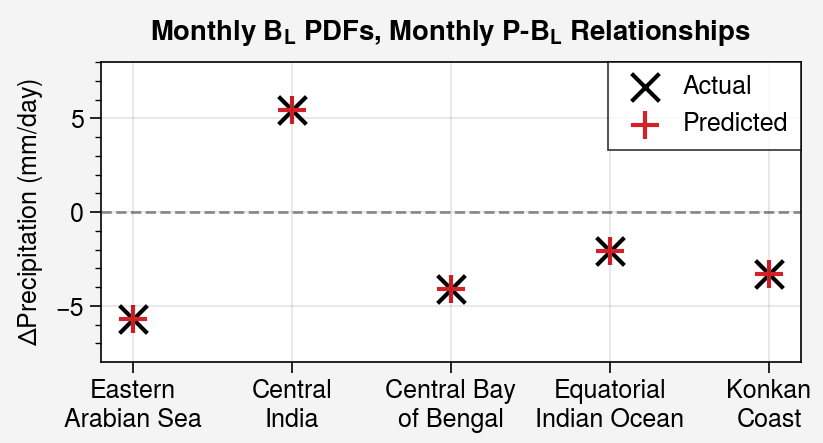

Eastern Arabian Sea: -0.0026%
Central India: -0.0062%
Central Bay of Bengal: -0.0271%
Equatorial Indian Ocean: 0.0027%
Konkan Coast: 0.1374%


In [6]:
predprdiffs,realprdiffs = calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='monthly')

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Monthly $B_L$ PDFs, Monthly P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)',ylim=(-8,8))
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realprdiffs,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predprdiffs,color='#D42028',marker='+',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

for region,predprdiff,realprdiff in zip(REGIONS.keys(),predprdiffs,realprdiffs):
    percenterror = ((predprdiff-realprdiff)/realprdiff)*100
    print(f'{region}: {percenterror:.4f}%')

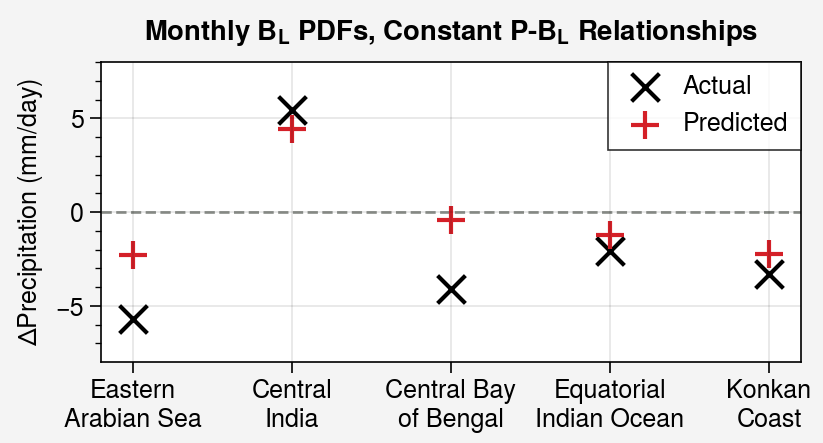

Eastern Arabian Sea: -59.5235%
Central India: -18.2006%
Central Bay of Bengal: -89.5550%
Equatorial Indian Ocean: -40.5208%
Konkan Coast: -32.7087%


In [7]:
predprdiffs,realprdiffs = calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='constant')

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Monthly $B_L$ PDFs, Constant P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)',ylim=(-8,8))
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realprdiffs,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predprdiffs,color='#D42028',marker='+',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()
fig.save(f'{SAVEDIR}/fig_4.png',dpi=600)

for region,predprdiff,realprdiff in zip(REGIONS.keys(),predprdiffs,realprdiffs):
    percenterror = ((predprdiff-realprdiff)/realprdiff)*100
    print(f'{region}: {percenterror:.4f}%')

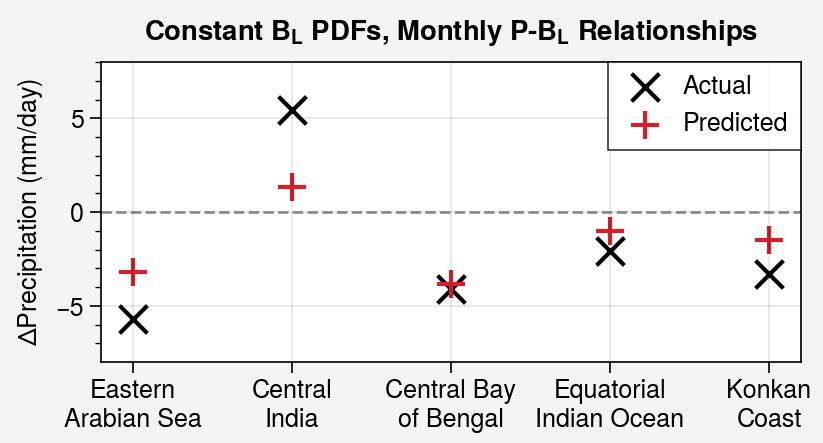

Eastern Arabian Sea: -43.5955%
Central India: -74.9369%
Central Bay of Bengal: -7.3997%
Equatorial Indian Ocean: -52.6268%
Konkan Coast: -55.5418%


In [9]:
predprdiffs,realprdiffs = calc_pr_diffs(stats,data,blpdftype='constant',binmeanprtype='monthly')

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Constant $B_L$ PDFs, Monthly P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)',ylim=(-8,8))
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realprdiffs,color='k',marker='x',s=100,label='Actual')
ax.scatter(regions,predprdiffs,color='#D42028',marker='+',s=100,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

for region,predprdiff,realprdiff in zip(REGIONS.keys(),predprdiffs,realprdiffs):
    percenterror = ((predprdiff-realprdiff)/realprdiff)*100
    print(f'{region}: {percenterror:.4f}%')

In [18]:
def calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='monthly',regions=REGIONS):
    for i,region in enumerate(regions):
        print(region)
        regionstats = stats.sel(region=region)
        regiondata  = get_region(data,region)
        if blpdftype=='constant':
            blpdf = get_pdf(regionstats.sum(dim='month'),bintype='1D',precipitating=False)
        if binmeanprtype=='constant':
            binmeanpr = get_bin_mean_pr(regionstats.sum(dim='month'),bintype='1D')
        predprlist = []
        realprlist = []
        months = [6, 7] if i < 3 else [7, 8]
        for month in months:
            print(f' {month}')
            monthstats = regionstats.sel(month=month)
            monthdata  = get_month(regiondata,month)
            if blpdftype=='monthly':
                blpdf = get_pdf(monthstats,bintype='1D',precipitating=False)
            if binmeanprtype=='monthly':
                binmeanpr = get_bin_mean_pr(monthstats,bintype='1D')
            predpr = np.nansum(blpdf*binmeanpr)
            realpr = monthdata.pr.mean(dim=['lat','lon','time']).values
            print(f'  Pred:{predpr:3f}')
            print(f'  Real:{realpr:3f}')

calc_pr_diffs(stats,data,blpdftype='monthly',binmeanprtype='constant')

Eastern Arabian Sea
 6
  Pred:6.767504
  Real:9.200132
 7
  Pred:4.471599
  Real:3.527935
Central India
 6
  Pred:6.212560
  Real:5.848648
 7
  Pred:10.661768
  Real:11.287820
Central Bay of Bengal
 6
  Pred:9.053566
  Real:11.612377
 7
  Pred:8.623314
  Real:7.493169
Equatorial Indian Ocean
 7
  Pred:3.584837
  Real:3.695996
 8
  Pred:2.347258
  Real:1.615306
Konkan Coast
 7
  Pred:8.717261
  Real:7.839397
 8
  Pred:6.509015
  Real:4.557774


In [30]:
def get_bin_edges(key,binparams=BINPARAMS):
    varname  = binparams[key]
    binedges = np.arange(varname['min'],varname['max']+varname['width'],varname['width'])
    return binedges

def calc_binned_stats(data,binparams=BINPARAMS,prthresh=PRTHRESH):
    blbins      = get_bin_edges('bl')
    blidxs      = ((data.bl.values-binparams['bl']['min'])/binparams['bl']['width']+0.5).astype(int)
    nblbins     = blbins.size
    Q0 = np.zeros((nblbins))
    Q1 = np.zeros((nblbins))
    for timeidx in range(len(data.time)):
        for latidx in range(len(data.lat)):
            for lonidx in range(len(data.lon)):
                prval       = data.pr.values[timeidx,latidx,lonidx]
                blidx       = blidxs[timeidx,latidx,lonidx]
                validpr     = np.isfinite(prval)
                validbl     = (0<=blidx<nblbins)
                if validbl & validpr:
                    Q0[blidx] += 1 
                    Q1[blidx] += prval
    ds = xr.Dataset(data_vars={'Q0':(('bl'),Q0),'Q1':(('bl'),Q1)},coords={'bl':blbins})
    ds.Q0.attrs     = dict(long_name='Count of points in each bin')
    ds.Q1.attrs     = dict(long_name='Sum of precipitation in each bin',units='mm/day')
    ds.bl.attrs     = dict(long_name='Average buoyancy in the lower troposphere',units='m/s²')
    return ds

def create_time_subsample(data,yearsinsample=5):
    allyears = np.unique(data.time.dt.year.values)
    selectedyears = np.random.choice(allyears,size=yearsinsample,replace=False)
    yearsmask = np.isin(data.time.dt.year,selectedyears)
    subsample = data.sel(time=yearsmask)
    return subsample
    
def get_bootstrap_analysis(regiondata,nbootstrap,yearsinsample):
    results = []
    for _ in range(nbootstrap):
        sample = create_time_subsample(regiondata,yearsinsample=yearsinsample)
        samplestats = calc_binned_stats(sample)
        results.append(samplestats)
    return results



# Get time subsample

In [35]:
# realprdiffs = []
# for i,region in enumerate(REGIONS):
#     regiondata = get_region(data,region)
#     realprlist = []
#     months = [6,7] if i<3 else [7,8]
#     for month in months:
#         monthdata = get_month(regiondata,month)
#         realpr    = monthdata.pr.mean(dim=['lat','lon','time']).values
#         realprlist.append(realpr)
#     realprdiffs.append(realprlist[1]-realprlist[0])    
# realprdiffs = np.asarray(realprdiffs)

In [31]:
nbootstrap    = 1000
yearsinsample = 5



for i,region in enumerate(REGIONS):
    regiondata = get_region(data,region)

    binmeanprlist = []
    for _ in range(nbootstrap):
        sample = create_time_subsample(regiondata,yearsinsample)
        samplestats = calc_binned_stats(sample)
        binmeanpr = get_bin_mean_pr(sample,bintype='1D')
        binmeanprlist.append(binmeanpr)


    months = [6,7] if i<3 else [7,8]
    for month in months:
        monthstats = stats.sel(region=region,month=month)
        blpdf = get_pdf(monthstats,bintype='1D',precipitating=False)

        predprensemble = []
        for binmeanpr in binmeanprensemble:
            predpr = np.sum(blpdf*binmeanpr)
            preprensemble.append(predpr)


predprdiffs = []
realprdiffs = []
predprdiffsensemble = []
for i,region in enumerate(REGIONS):
    regiondata = get_region(data,region)
    samples    = bootstrap_analysis(regiondata,nbootstrap=nbootstrap,grouplength=grouplength)
    binmeanprensemble = [get_bin_mean_pr(sample,bintype='1D') for sample in samples]
    predprensemblelist = []
    predprlist = []
    realprlist = []
    months = [6,7] if i<3 else [7,8]
    for month in months:
        blpdf = get_pdf(stats.sel(region=region,month=month),bintype='1D',precipitating=False)
        predprensemble = [np.sum(blpdf*binmeanpr) for binmeanpr in binmeanprensemble]
        predprensemblelist.append(predprensemble)
    predprlist = [np.mean(ensemble) for ensemble in predprensemblelist]
    realprlist = [get_month(regiondata,month).pr.mean(dim=['lat','lon','time']).values for month in months]
    predprdiffs.append(predprlist[1]-predprlist[0])
    realprdiffs.append(realprlist[1]-realprlist[0])
    predprdiffsensemble.append(np.array(predprensemblelist[1])-np.array(predprensemblelist[0]))
predprdiffs = np.array(predprdiffs)
realprdiffs = np.array(realprdiffs)
predprdiffsensemble = np.array(predprdiffsensemble)

<xarray.Dataset>
Dimensions:  (bl: 281)
Coordinates:
  * bl       (bl) float64 -0.6 -0.5975 -0.595 -0.5925 ... 0.095 0.0975 0.1
Data variables:
    Q0       (bl) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Q1       (bl) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [11]:
import multiprocessing as mp
from functools import partial
import numpy as np
import xarray as xr
import logging
import time

def process_region(data,stats,region,nbootstrap,grouplength):
    try:
        print(f'- Started processing {region} on {mp.current_process().name}')
        starttime = time.time()
        
        regiondata = get_region(data,region)
        samples    = bootstrap_analysis(regiondata,nbootstrap,grouplength)
        
        binmeanprensemble = [get_bin_mean_pr(sample,bintype='1D') for sample in samples]
        
        months = [6,7] if list(REGIONS.keys()).index(region)<3 else [7,8]
        blpdfs = [get_pdf(stats.sel(region=region,month=month),bintype='1D',precipitating=False) for month in months]
        
        predprensemblelist = [[np.sum(blpdf*binmeanpr) for binmeanpr in binmeanprensemble] for blpdf in blpdfs]
        predprlist = [np.mean(ensemble) for ensemble in predprensemblelist]
        realprlist = [get_month(regiondata,month).pr.mean(dim=['lat','lon','time']).values for month in months]
        
        predprdiff = predprlist[1]-predprlist[0]
        realprdiff = realprlist[1]-realprlist[0]
        predprdiffensemble = np.array(predprensemblelist[1])-np.array(predprensemblelist[0])
        
        endtime = time.time()
        print(f'Completed processing {region} in {endtime-starttime:.2f}s')
        return predprdiff,realprdiff,predprdiffensemble
    except Exception as e:
        print(f'Error processing {region}: {str(e)}')
        return None


nbootstrap  = 5 #1000
yearsinsample = 2 #5

# Partial function
process_region_partial = partial(process_region,nbootstrap=nbootstrap,grouplength=grouplength)

# Get the number of available CPU cores
ncores = 32 # mp.cpu_count()
print(f'Using {ncores} CPU cores')

# Create a pool of workers
starttime = time.time()
with mp.Pool(ncores) as pool:
    print('Starting parallel processing...')
    # Apply the process_region function to all regions in parallel
    results = pool.starmap(process_region_partial,[(data,stats,region) for region in REGIONS.keys()])
endtime = time.time()
print(f'Parallel processing completed in {endtime-starttime:.2f}s')

if None in results:
    print("Some regions failed to process")
else:
    print("All regions processed successfully")
    predprdiffs, realprdiffs, predprdiffsensemble = map(np.array, zip(*results))
    print(f"Shape of predprdiffs: {predprdiffs.shape}")
    print(f"Shape of realprdiffs: {realprdiffs.shape}")
    print(f"Shape of predprdiffsensemble: {predprdiffsensemble.shape}")
    print("Processing completed")

# predprdiffs,realprdiffs,predprdiffsensemble = map(np.array,zip(*results))
# print('Processing completed')

Using 32 CPU cores
Starting parallel processing...
Started processing Eastern Arabian Sea on ForkPoolWorker-33
Started processing Central India on ForkPoolWorker-34
Started processing Central Bay of Bengal on ForkPoolWorker-35
Started processing Equatorial Indian Ocean on ForkPoolWorker-36
Started processing Konkan Coast on ForkPoolWorker-37
- Completed bootstrap analysis
- Calculated bin mean precipitation
- Calculated monthly BL PDFs
Completed processing Konkan Coast in 599.15s
- Completed bootstrap analysis
- Calculated bin mean precipitation
- Calculated monthly BL PDFs
Completed processing Central Bay of Bengal in 730.16s
- Completed bootstrap analysis
- Calculated bin mean precipitation
- Calculated monthly BL PDFs
Completed processing Equatorial Indian Ocean in 1000.43s


Process ForkPoolWorker-37:
Process ForkPoolWorker-35:
Process ForkPoolWorker-36:
Process ForkPoolWorker-64:
Process ForkPoolWorker-60:
Process ForkPoolWorker-51:
Process ForkPoolWorker-61:
Process ForkPoolWorker-50:
Process ForkPoolWorker-62:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-47:
Process ForkPoolWorker-49:
Process ForkPoolWorker-40:
Process ForkPoolWorker-56:
Process ForkPoolWorker-45:
Process ForkPoolWorker-58:
Process ForkPoolWorker-43:
Process ForkPoolWorker-59:
Process ForkPoolWorker-46:
Process ForkPoolWorker-42:
Process ForkPoolWorker-39:
Process ForkPoolWorker-44:
Process ForkPoolWorker-63:
Process ForkPoolWorker-53:
Process ForkPoolWorker-57:
Process ForkPoolWorker-41:
Process ForkPoolWorker-48:
Process ForkPoolWorker-55:
Process ForkPoolWorker-34:
Process ForkPoolWorker-33:
Process ForkPoolWorker-38:


KeyboardInterrupt: 

In [ ]:
nbootstrap  = 3 # Needs to be 1000
grouplength = 1 # Needs to be 5

predprdiffs = []
realprdiffs = []
predprdiffsensemble = []
for i,region in enumerate(REGIONS):
    regiondata = get_region(data,region)
    samples    = bootstrap_analysis(regiondata,nbootstrap=nbootstrap,grouplength=grouplength)
    binmeanprensemble = [get_bin_mean_pr(sample,bintype='1D') for sample in samples]
    predprensemblelist = []
    predprlist = []
    realprlist = []
    months = [6,7] if i<3 else [7,8]
    for month in months:
        blpdf = get_pdf(stats.sel(region=region,month=month),bintype='1D',precipitating=False)
        predprensemble = [np.sum(blpdf*binmeanpr) for binmeanpr in binmeanprensemble]
        predprensemblelist.append(predprensemble)
    predprlist = [np.mean(ensemble) for ensemble in predprensemblelist]
    realprlist = [get_month(regiondata,month).pr.mean(dim=['lat','lon','time']).values for month in months]
    predprdiffs.append(predprlist[1]-predprlist[0])
    realprdiffs.append(realprlist[1]-realprlist[0])
    predprdiffsensemble.append(np.array(predprensemblelist[1])-np.array(predprensemblelist[0]))
predprdiffs = np.array(predprdiffs)
realprdiffs = np.array(realprdiffs)
predprdiffsensemble = np.array(predprdiffsensemble)

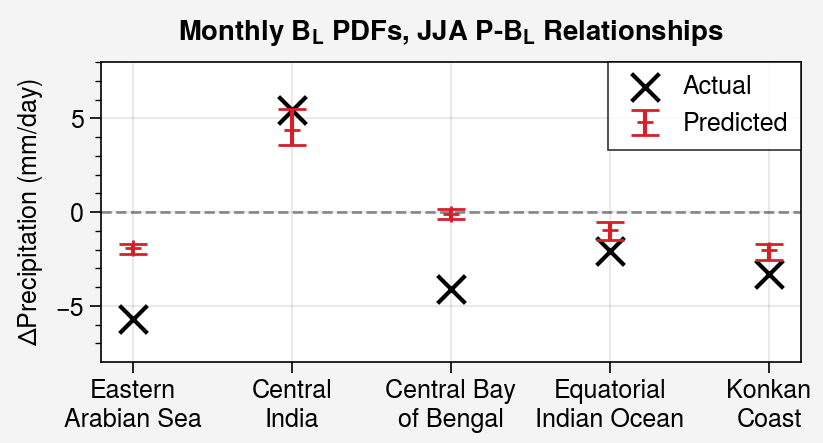

Eastern Arabian Sea: Error bars do NOT bound P change
Central India: Error bars bound P change
Central Bay of Bengal: Error bars do NOT bound P change
Equatorial Indian Ocean: Error bars do NOT bound P change
Konkan Coast: Error bars do NOT bound P change


In [68]:
ci   = np.percentile(predprdiffsensemble,[2.5,97.5],axis=1).T
yerr = (predprdiffs-ci[:,0],ci[:,1]-predprdiffs)

regions = ['Eastern\nArabian Sea','Central\nIndia','Central Bay\nof Bengal','Equatorial\nIndian Ocean','Konkan\nCoast']
fig,ax  = pplt.subplots(refheight=1.5,refwidth=3.5)
ax.format(suptitle='Monthly $B_L$ PDFs, JJA P-$B_L$ Relationships',ylabel='$\Delta$Precipitation (mm/day)',ylim=(-8,8))
ax.axhline(y=0,color='grey',linestyle='--',linewidth=1,zorder=0)
ax.scatter(regions,realprdiffs,color='k',marker='x',s=100,label='Actual')
ax.errorbar(regions,predprdiffs,yerr=yerr,color='#D42028',fmt='+',linestyle='',capsize=5,label='Predicted')
ax.legend(loc='ur',ncols=1)
pplt.show()

for i,(real,pred,cii) in enumerate(zip(realprdiffs,predprdiffs,ci)):
    if cii[0] <= real <= cii[1]:
        print(f"{list(REGIONS.keys())[i]}: Error bars bound P change")
    else:
        print(f"{list(REGIONS.keys())[i]}: Error bars do NOT bound P change")